In [1]:
import psycopg2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint

try:
  con
except NameError:
  con = psycopg2.connect(user="postgres", dbname="delaycompdb", password="coap")
  con.set_session(readonly=True, autocommit=False)
    

In [2]:
exp_data_sql = """
SELECT 
    ex.exp_id,
    ex.num_trials, 
    d.dnid,
    n.*
FROM 
	experiment ex
  JOIN deployed_node d ON d.exp_id = ex.exp_id
  JOIN node n ON d.node_id = n.node_id
GROUP BY
	ex.exp_id,
    n.node_id,
    d.dnid
ORDER BY
  ex.attacker_rate,
  ex.proxy_connections
;
"""
lay_of_the_land = pd.read_sql_query(exp_data_sql, con)
con.commit()
print("\n".join(lay_of_the_land.exp_id.unique().tolist()))
lay_of_the_land

double_delay_90conns_1client_0attackers_newreala
custom_mpm_server_conf_1client_0attackers_newreala


,exp_id,num_trials,dnid,node_id,node_name,hardware_type,operating_system
0,double_delay_90conns_1client_0attackers_newreala,1,11,4,proxy,microcloud,ubuntu1804-std
1,custom_mpm_server_conf_1client_0attackers_newr...,1,5,4,proxy,microcloud,ubuntu1804-std
2,custom_mpm_server_conf_1client_0attackers_newr...,1,6,2,receiver,microcloud,ubuntu1804-std
3,double_delay_90conns_1client_0attackers_newreala,1,8,5,client1,microcloud,ubuntu1804-std
4,custom_mpm_server_conf_1client_0attackers_newr...,1,4,1,originserver,microcloud,ubuntu1804-std
5,custom_mpm_server_conf_1client_0attackers_newr...,1,1,3,attacker,microcloud,ubuntu1804-std
6,double_delay_90conns_1client_0attackers_newreala,1,7,3,attacker,microcloud,ubuntu1804-std
7,double_delay_90conns_1client_0attackers_newreala,1,9,7,client2,microcloud,ubuntu1804-std
8,custom_mpm_server_conf_1client_0attackers_newr...,1,3,6,client2,pc2133,ubuntu1804-std
9,double_delay_90conns_1client_0attackers_newreala,1,10,1,originserver,microcloud,ubuntu1804-std


In [3]:
client_rps_sql = """
WITH base_rps_table AS(
	SELECT
		d.exp_id,
		n.node_name,
		e.trial,
		COUNT(DISTINCT e.message_marker) AS sent_messages,
		MAX(e.observe_timestamp) - MIN(e.observe_timestamp) AS active_time_sec
	FROM
		deployed_node d
		JOIN node n ON n.node_id = d.node_id
		JOIN event e ON e.observer_id = d.dnid
		JOIN experiment ex ON ex.exp_id = d.exp_id
	WHERE
		n.node_name LIKE '%client%' OR
		n.node_name LIKE '%attacker%'
	GROUP BY
		d.exp_id,
		n.node_name,
		e.trial
)

SELECT *, sent_messages / active_time_sec AS average_rps
FROM base_rps_table;
"""

df = pd.read_sql_query(client_rps_sql, con)
con.commit()

# Add number of attackers and clients in the df
ndf = df.groupby(by=["exp_id"]).agg(
    has_attacker=("node_name", lambda x: int(any(x.str.startswith("attacker")))),
    num_clients=("node_name", lambda x: x.nunique() - any(x.str.startswith("attacker"))),
)
df = df.merge(ndf, on="exp_id")

df

,exp_id,node_name,trial,sent_messages,active_time_sec,average_rps,has_attacker,num_clients
0,custom_mpm_server_conf_1client_0attackers_newr...,client1,1,1839,98.588154,18.653357,0,1
1,double_delay_90conns_1client_0attackers_newreala,client1,1,933,97.205171,9.598255,0,1


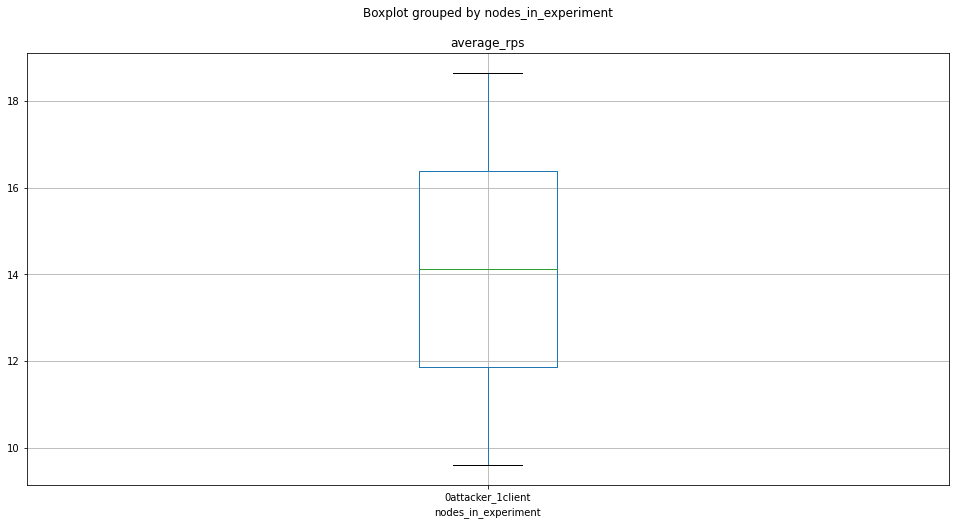

,exp_id,node_name,trial,sent_messages,active_time_sec,average_rps,has_attacker,num_clients,nodes_in_experiment,other_nodes_in_experiment
0,custom_mpm_server_conf_1client_0attackers_newr...,client1,1,1839,98.588154,18.653357,0,1,0attacker_1client,1client_0attacker
1,double_delay_90conns_1client_0attackers_newreala,client1,1,933,97.205171,9.598255,0,1,0attacker_1client,1client_0attacker


In [4]:
df["nodes_in_experiment"] = df["has_attacker"].astype(str) + "attacker_" + df["num_clients"].astype(str) + "client"
df["other_nodes_in_experiment"] = df["num_clients"].astype(str) + "client_" + df["has_attacker"].astype(str) + "attacker"
tdf = df[df["node_name"] != "attacker"]
tdf.boxplot(by="nodes_in_experiment", column="average_rps")
plt.show()

tdf.groupby(by=["nodes_in_experiment"]).count()

df

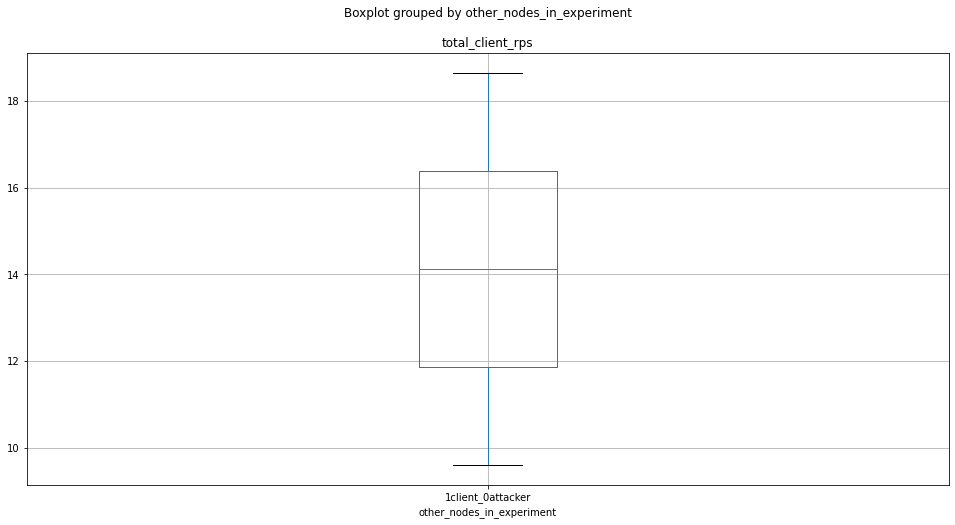

,exp_id,trial,total_client_rps,nodes_in_experiment,other_nodes_in_experiment
0,custom_mpm_server_conf_1client_0attackers_newr...,1,18.653357,0attacker_1client,1client_0attacker
1,double_delay_90conns_1client_0attackers_newreala,1,9.598255,0attacker_1client,1client_0attacker


In [5]:
# total_client_df = tdf.groupby(by=["exp_id"]).agg(
#     total_client_rps=("average_rps", "sum"),
#     nodes_in_experiment=("nodes_in_experiment", "first"),
# ).reset_index()

# total_client_df.boxplot(by="nodes_in_experiment", column="total_client_rps")

# total_client_df

total_client_df = tdf.groupby(by=["exp_id", "trial"]).agg(
    total_client_rps=("average_rps", "sum"),
    nodes_in_experiment=("nodes_in_experiment", "first"),
    other_nodes_in_experiment=("other_nodes_in_experiment", "first"),
).reset_index()

total_client_df.boxplot(by="other_nodes_in_experiment", column="total_client_rps")
plt.show()

total_client_df